[Pima Indians Diabetes - EDA & Prediction (0.906)](https://www.kaggle.com/vincentlugat/pima-indians-diabetes-eda-prediction-0-906/notebook#Pima-Indians-Diabetes---EDA-&-Prediction-(0.906))

* Accuracy - 5 Folds - LightGBM : 89.8%
* Accuracy - 5 Folds - LightGBM & KNN : 90.6%
---
목차  
1. Load Libraries and read the data
 - 1.1 Load Libraries
 - 1.2 Read the data

2. Overview
 - 2.1 Head
 - 2.2 Target
 - 2.3 Missing Values

3. Replace missing values and EDA
 - 3.1 Insulin
 - 3.2 Gluscose
 - 3.3 SkinThcikness
 - 3.4 BloodPressure
 - 3.5 BMI

4. New Features (16) and EDA

5. Prepare dataset
 - 5.1 StandardScaler and LabelEncoder
 - 5.2 Correlation Matrix
 - 5.3 X and y
 - 5.4 Model Performance
 - 5.5 Scores Table

6. Machine Learning
 - 6.1 RandomSearch + LightGBM - Accuracy = 89.8%
 - 6.2 LightGBM - Discrimination Threshold
 - 6.3 GridSearch + LightGBM & KNN - Accuracy = 90.6%
 - 6.4 LightGBM & KNN - Discrimination Threshold

7. Credits

이 노트북은 다음과 같은 다양한 개념으로 머신러닝에 대해 끝까지 알려준다. 
 * Completing missing values (most important part)  
   누락된 값 완성(가장 중요한 부분이다.)

 * Exploratory data analysis  
  탐색적 데이터 분석

 * Creating new features (to increase accuracy)
  새로운 변수 생성(정확도 향상 위함)

 * Encoding features  
   변수 범주화

 * Using LightGBM and optimize hyperparameters  
   LightGBM 사용과 매개변수 최적화

 * Adding a KNN to LGBM to beat 90% accuracy (voting classifier)  
   90% 정확도를 능가하는 LGBM에 KNN 추가(투표 분류기)

# 1. Load libraries and read the data

## 1.1 Load Libraries

In [1]:
# !pip install squarify
# print('-'*50)
# !pip install chart_studio
# print('-'*50)
# !pip install cufflinks

In [2]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script 
  src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [3]:
import os
os.chdir('/content/drive/MyDrive/kaggle/pima')
# Classic, data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio
import plotly.offline as py
import plotly.graph_objects as go
from plotly.offline import iplot

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify  #!pip install

# Data Processing, metrics ans modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold #??

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager #??
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0 :.0f}s")

# ignore warning message
import warnings
warnings.filterwarnings('ignore')

## 1.2 Read data

In [4]:
data = pd.read_csv('diabetes.csv')

# 2.Overview

## 2.1 Head
Checking data head and info

In [5]:
display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

Pregnancies  Glucose  BloodPressure  ...  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72  ...                     0.627   50        1
1            1       85             66  ...                     0.351   31        0
2            8      183             64  ...                     0.672   32        1
3            1       89             66  ...                     0.167   21        0
4            0      137             40  ...                     2.288   33        1

[5 rows x 9 columns]

데이터 세트는 여러 의학적 예측 변수(독립)와 하나의 목표(종속) 변수인 결과로 구성된다. 독립 변수에는 환자의 임신 횟수, BMI, 인슐린 수치, 연령 등이 포함된다.

**What is diabetes?**
NIH에 따르면 당뇨는 혈당이 너무 높을때 발생하는 질병이다. 혈당은 주요 에너지원이며 섭취하는 음식에서 나온다. 췌장에서 생성되는 호르몬인 인슐린은 음식의 포도당이 세포로 들어가 에너지로 사용되도록 돕는다. 때때로 몸이 인슐린이 충분히 만들지 못하거나 인슐린을 잘 사용하지 않은 경우에 포도당은 혈액에 남아 세포에 전달되지 않는다.   

시간이 지남에 따라 혈액에 너무 많은 포도당이 있으면 건강 문제가 발생할 수 있다. 당뇨병은 치료법이 없지만 당뇨병을 관리하고 건강을 유지하기 위한 조치를 취할 수 있다.  

때때로 사람들은 당뇨병을 "a touch of sugar" 또는 "borderlin diabetes"라고 부른다. 이 용어는 누군가가 실제로 당뇨병이 없거나 덜 심각한 경우를 암시하지만 모든 당뇨병 사례는 심각하다. 


* **당뇨병의 유형은 무엇인가?**
 - 당뇨병의 가장 흔한 유형은 제 1형, 제 2형, 및 임신성 당뇨병이다. 

* **제 1형 당뇨**   
 - 제 1형 당뇨가 있는경우 신체에서 인슐린이 생성되지 않는다. 면역 체계는 인슐린을 만드는 췌장의 세포를 공격하고 파괴한다.  
 - 제 1형 당뇨병은 모든 유형에서 나타날 수 있지만 일반적으로 어린이와 젊은 성인에서 진단되며 환자는 매일 인슐린을 투여해야 한다.

* **제 2형 당뇨**
 - 제 2형 당뇨가 있는 경우, 신체는 인슐린을 잘 만들거나 사용하지 않는다. 어린 시절을 포함해 모든 연령에서 제 2형 당뇨병이 발병할 수 있다. 그러나 이러한 유형의 당뇨병은 중년 및 노년층에서 가장 흔하게 발생한다.

* **임신성 당뇨병**
 - 일부 여성이 임신한 경우 발생한다. 대부분의 경우 이러한 유형의 당뇨병은 아기가 태어난 후 사라진다. 그러나 임신성 당뇨병이 있는 경우 낮중에 2형 당뇨병이 발병할 가능성이 더 높아진다. 
 - 때때로 임신 중 진단된 당뇨병은 실제 2형 당뇨병이다.

* **그 외 당뇨**
 - 일반적이지 않은 유형에는 유전형과 단일 유전자 당뇨병, 낭포성 섬유증 관련 당뇨병이 있다. 

## 2.2 Target
target의 분포는 어떻게 되는가?

아래 그래프는 데이터의 불균형을 보여준다.

In [6]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#-------------- COUNT ------------
def target_count():
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력

    trace = go.Bar(x = data['Outcome'].value_counts().values.tolist(),
                   y = ['healthy', 'diabetic'],
                   orientation = 'h',
                   text = data['Outcome'].value_counts().values.tolist(),
                   textfont=dict(size=15),
                   textposition = 'auto',
                   opacity = 0.8, marker =dict(
                       color=['lightskyblue','gold'],
                       line = dict(color='#000000', width=1.5)))

    layout = dict(title = 'Count of Outcome variable')                   
    fig = dict(data = [trace], layout = layout)
    py.iplot(fig)
    
# -------------- PERCENTAGE --------------
def target_percent():
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력

    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), textfont=dict(size=15), opacity=0.8,
                   marker = dict(colors = ['lightskyblue', 'gold'], line=dict(color='#000000', width=1.5)))
    layout = dict(title = 'Distribution of Outcome variable')
    fig = dict(data = [trace], layout = layout)
    py.iplot(fig)
    


In [7]:
target_count()
target_percent()

Output hidden; open in https://colab.research.google.com to view.

## 2.3 Missing Values
data.head()에서 일부 기능이 0을 포함하는 것을 보았지만 여기서는 의미가 없으며 이는 누락된 값을 나타낸다. 아래에서 0 값을 NaN으로 바꾼다.

In [8]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin', 'BMI']].replace(0, np.nan)

이제 결측값이 있는 위치를 확인할 수 있다.

In [9]:
# 데이터 세트의 모든 누락된 값을 감지하기 위해 누락된 플롯 정의
def missing_plot(dataset, key):
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력
        
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    perncetage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'], opacity = 0.8, text = percentage_null['Count'], textposition='auto',
                   marker = dict(color='#7EC0EE', line=dict(color='#000000',width = 1.5)))
    
    layout = dict(title = "Missing Values (count & %)")

    fig = dict(data = [trace], layout = layout)
    py.iplot(fig)

In [10]:
# Plotting
configure_plotly_browser_state()
missing_plot(data, 'Outcome')

Output hidden; open in https://colab.research.google.com to view.

Missing Values : 
 * Insulin = 48.7% - 374
 * SkinThickness = 29.56% - 227
 * BloodPressure = 4.56% - 35
 * BMI = 1.43% - 11
 * Glucose = 0.65% - 5

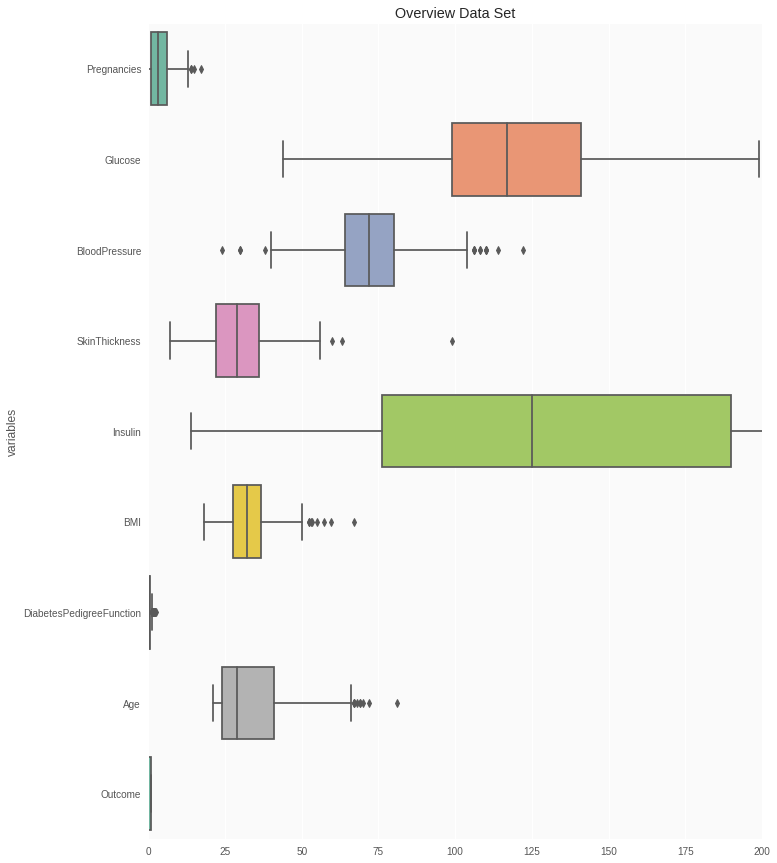

In [11]:
plt.style.use('ggplot')  # using ggplot2 style visuals

f, ax = plt.subplots(figsize=(11,15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('variables')
plt.title('Overview Data Set')
ax = sns.boxplot(data = data,
                 orient = 'h',
                 palette = 'Set2')

결측값은 모두 NaN으로 인코딩 되었으며, 이러한 NaN값을 채우려변 대상의 데이터 분포에 대해 이해해야 한다. 

In [12]:
def correlation_plot():
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력
    
    # correlation 
    correlation = data.corr()
    # tick labels
    matrix_cols = correlation.columns.tolist()
    # convert to array
    corr_array = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale = 'Viridis',
                       colorbar = dict(),
                       )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            # autosize = False,
                            # height = 1400,
                            # width = 1600,
                            margin = dict(r = 0, l = 100,
                                          t = 0, b = 100),
                            yaxis = dict(tickfont = dict(size=9)),
                            xaxis = dict(tickfont = dict(size=9))
                            ))
    fig = go.Figure(data = [trace], layout = layout)
    py.iplot(fig)

상관 행렬은 변수 집합 간의 상관 계수를 보여주는 테이블이다. 표의 각 확률 변수(Xi)는 표(Xj)의 다른 값 각각과 상관 관계가 있다. 이를 통해 가장 높은 상관 관계를 가진 쌍을 볼 수 있다.

In [13]:
configure_plotly_browser_state()
correlation_plot()

Output hidden; open in https://colab.research.google.com to view.

아래에서 NaN값을 변수의 평균으로 대체해 LGBM의 정확도를 확인할 수 있다.(중앙값과 동일한 결과)


# 3.Replace missing values and EDA

In [14]:
def median_target(var):
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

## 3.1 Insulin
 * Insulin : 2-Hour serum insulin (mu U/ml)

In [15]:
def plot_distribution(data_select, size_bin) :  
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    # Add title
    fig.update_layout(title_text=data_select)
    
    # fig.update_layout(
    #     title_text=data_select,
    #     font =dict(
    #         size=18
    #     )
    # )
    
    py.iplot(fig, filename = 'Density plot')

In [16]:
plot_distribution('Insulin',0)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
median_target('Insulin')

Outcome  Insulin
0        0    102.5
1        1    169.5

target에 따른 인슐린의 중앙값은 다르다.  
* 건강한 사람의 경우 : 102.5
* 당뇨병 환자의 경우 : 169.5

In [18]:
data.loc[(data['Outcome']==0) & (data['Insulin'].isnull()), 'Insulin'] =102.5
data.loc[(data['Outcome']==1) & (data['Insulin'].isnull()), 'Insulin'] =169.5

## 3.2 Glucose
 * Glucose : Plasma glucose concentration a 2 hours in an oral glucose tolerance test


In [19]:
plot_distribution('Glucose',0)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
median_target('Glucose')

Outcome  Glucose
0        0    107.0
1        1    140.0

In [21]:
data.loc[(data['Outcome'] == 0) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1) & (data['Glucose'].isnull()), 'Glucose'] = 140

* 건강한 사람 : 107
* 당뇨병 환자 : 140

## 3.3 SkinThickness
* SkinThickness : Triceps skin fold thickness (mm)

In [22]:
plot_distribution('SkinThickness', 10)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
median_target('SkinThickness')

Outcome  SkinThickness
0        0           27.0
1        1           32.0

In [24]:
data.loc[(data['Outcome'] == 0) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

* 건강한 사람 : 27
* 당뇨병 환자 : 32

## 3.4 BloodPressure
* BloodPressure : Diastolic blood pressure (mm Hg)
  이완기 혈압

In [25]:
plot_distribution('BloodPressure', 5)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
median_target('BloodPressure')

Outcome  BloodPressure
0        0           70.0
1        1           74.5

In [27]:
data.loc[(data['Outcome'] == 0) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

## 3.5 BMI
* BMI : Body mass index (weight in kg/(height in m)^2)

In [28]:
plot_distribution('BMI',0)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
median_target('BMI')

Outcome   BMI
0        0  30.1
1        1  34.3

In [30]:
data.loc[(data['Outcome'] == 0) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1) & (data['BMI'].isnull()), 'BMI'] = 34.3

* **Age** : Age(years)
* **DiabetesPedigreeFunction** : Diabetes pedigree function
* **Pregnancies** : Number of times pregnant

In [31]:
# plot distribution
plot_distribution('Age',0)
plot_distribution('Pregnancies',0)
plot_distribution('DiabetesPedigreeFunction',0)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
missing_plot(data, 'Outcome')

Output hidden; open in https://colab.research.google.com to view.

모든 변수들의 결측치는 제거되었으며 이제 새로운 변수를 생성한다.

# 4.New features (16) and EDA
 - 여기에서 3개의 플롯 함수를 정의한다.

In [33]:
def plot_feat1_feat2(feat1, feat2) :
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력  
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    feats_layout = go.Layout(
        dict(title = feat1 +" "+"vs"+" "+ feat2,
        yaxis = dict(title = feat2, zeroline = False),
        xaxis = dict(title = feat1, zeroline = False))
        )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=feats_layout)
    py.iplot(fig)

In [34]:
def barplot(var_select, sub) :
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력
    
    tmp1 = data[(data['Outcome'] != 0)]
    tmp2 = data[(data['Outcome'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Outcome']), )
    tmp3['% diabetic'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='diabetic',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='healthy', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['% diabetic'],
        yaxis = 'y2',
        name='% diabetic', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% diabetic'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [35]:
# Plot3
# 각 변수 reparttion vs target 양상을 시각화하기 위해 파이 플롯을 정의한다.
def plot_pie(var_select, sub):
    configure_plotly_browser_state() # plot 출력
    enable_plotly_in_cell()  # plot title 입력

    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]

    col = ['Silver','mediumturquoise','#CF5C36','lightblue','magenta','#FF5D73','#F2D7EE','mediumturquoise']
    
    trace1 = go.Pie(values = D[var_select].value_counts().values.tolist(),
                    labels = D[var_select].value_counts().keys().tolist(),
                    textfont = dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    domain = dict(x = [.0, .48]),
                    name = 'Diabetic',
                    marker = dict(colors = col, line = dict(width = 1.5)))     
                    
    trace2 = go.Pie(values = H[var_select].value_counts().values.tolist(),
                    labels = H[var_select].value_counts().keys().tolist(),
                    textfont = dict(size=15), opacity =0.8,
                    hole = 0.5,
                    hoverinfo = 'label+percent+name',
                    marker = dict(line = dict(width = 1.5)),
                    domain = dict(x = [.52, 1]),
                    name = 'Healthy')

    layout = go.Layout(dict(title = var_select + 'distribution by target <br>' + (sub),
                            annotations = [dict(text = 'Diabetic'+' : '+'268',font = dict(size=13),showarrow = False, x=.22, y=-0.1),
                                           dict(text = 'Healthy'+' : '+'500', font = dict(size=13), showarrow = False, x=.8, y=-.1)]))
    
    fig = go.Figure(data = [trace1, trace2], layout = layout)
    py.iplot(fig)

## 4.1 Glucose and Age

In [36]:
plot_feat1_feat2('Glucose', 'Age')

Output hidden; open in https://colab.research.google.com to view.

건강한 사람의 경우
 * age <= 39
 * glucose <= 102

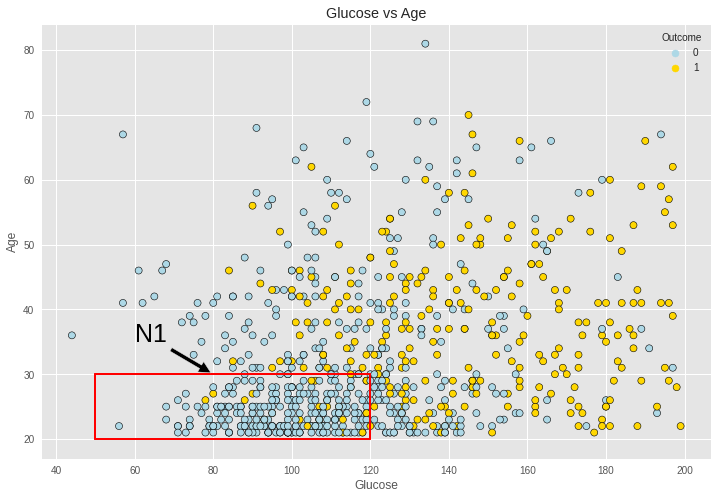

In [37]:
palette = {0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['Age'], hue = 'Outcome',
                      data = data, palette = palette, edgecolor = edgecolor)

plt.annotate('N1', size=25, color='black',xy=(80, 30), xytext=(60,35),
             arrowprops = dict(facecolor='black', shrink=0.05),)

plt.plot([50, 120], [30,30], linewidth=2, color='red')
plt.plot([120,120], [20,30], linewidth=2, color='red')
plt.plot([50,120],[20,20], linewidth=2, color='red')
plt.plot([50,50],[20,30],linewidth=2, color='red')
plt.title('Glucose vs Age')
plt.show()

In [38]:
data.loc[:,'N1'] = 0
data.loc[(data['Age'] <= 30) & (data['Glucose']<=120), 'N1'] = 1

In [39]:
barplot('N1', ':Glucose <= 120 and Age <= 30')

Output hidden; open in https://colab.research.google.com to view.

In [40]:
plot_pie('N1', '(Glucose <= 120  and Age <= 30)')

Output hidden; open in https://colab.research.google.com to view.

## 4.2 BMI
위키피디아에 따르면 "체질량지수(BMI) 또는 Quetelet 지수는 개인의 질량(체중)과 키에서 파생된 값이다. BMI는 체중을 신장의 제곱으로 나눈 값으로 정의되며, 일반적으로 킬로그램 단위의 질량과 미터 단위의 높이로 인해 kg/m2 단위로 표현된다.

(30kg/m^2 값이 비만의 한계이다.)

In [41]:
data.loc[:, 'N2'] = 0
data.loc[(data['BMI']<=30), 'N2'] = 1

In [42]:
barplot('N2', ' : BMI <= 30')

Output hidden; open in https://colab.research.google.com to view.

In [43]:
plot_pie('N2', 'BMI <= 30')

Output hidden; open in https://colab.research.google.com to view.

## 4.3 Pregnancies and Age

In [44]:
plot_feat1_feat2('Pregnancies','Age')

Output hidden; open in https://colab.research.google.com to view.

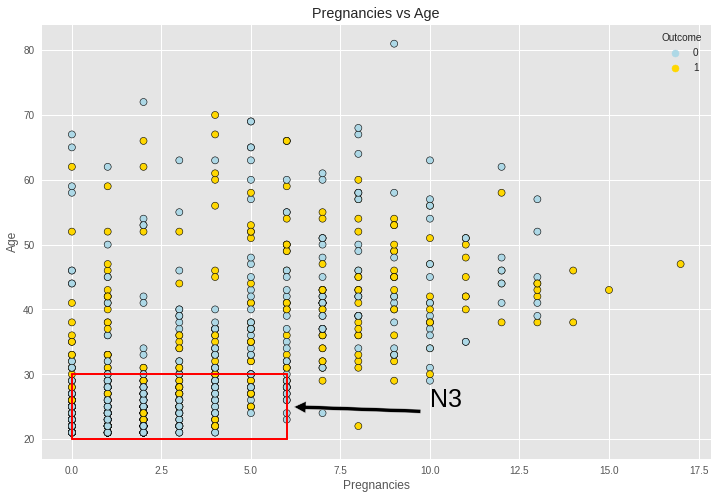

In [45]:
palette = {0:'lightblue', 1:'gold'}
edgecolor = 'black'

fig = plt.figure(figsize = (12,8))

ax1 = sns.scatterplot(x = data['Pregnancies'], y=data['Age'], hue = 'Outcome',
                      data = data, palette = palette, edgecolor =edgecolor)

plt.annotate('N3', size = 25, color = 'black', xy = (6,25), xytext = (10,25),
             arrowprops = dict(facecolor='black', shrink=0.05),)

plt.plot([0,6], [30, 30], linewidth = 2, color = 'red')
plt.plot([6,6], [20, 30], linewidth = 2, color = 'red')
plt.plot([0,6], [20, 20], linewidth = 2, color = 'red')
plt.plot([0,0], [20, 30], linewidth = 2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

In [46]:
data.loc[:,'N3'] = 0
data.loc[(data['Age']<=30) & (data['Pregnancies']<=6), 'N3'] = 1

In [47]:
barplot('N3', ': Age <= 30 and Pregnancies <= 6')

Output hidden; open in https://colab.research.google.com to view.

In [48]:
plot_pie('N3', 'Age <= 30 and Pregnanceis <= 6')

Output hidden; open in https://colab.research.google.com to view.

## 4.4 Glucose and BloodPressure

In [49]:
plot_feat1_feat2('Glucose', 'BloodPressure')

Output hidden; open in https://colab.research.google.com to view.

건강한 사람의 경우,  혈압 <= 80 / 포도당 <= 105로 집중되어 있다.

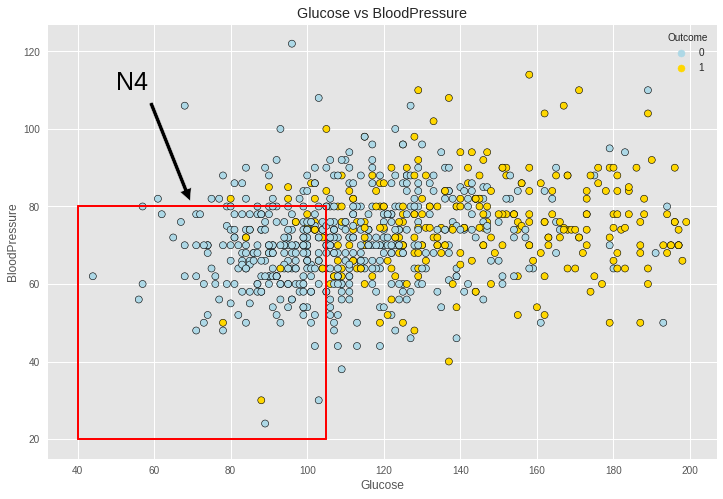

In [50]:
palette = {0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BloodPressure'], hue = 'Outcome',
                      data = data, palette = palette, edgecolor = edgecolor)

plt.annotate('N4', size=25, color = 'black', xy=(70, 80), xytext=(50,110),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.plot([40, 105], [80, 80], linewidth = 2, color = 'red')
plt.plot([40, 40], [20, 80], linewidth =2, color ='red')
plt.plot([40, 105], [20, 20], linewidth = 2, color = 'red')
plt.plot([105, 105], [20, 80], linewidth = 2, color = 'red')
plt.title('Glucose vs BloodPressure')
plt.show()

In [51]:
data.loc[:, 'N4'] = 0
data.loc[(data['Glucose']<=105) & (data['BloodPressure']<=80), 'N4'] = 1

In [52]:
barplot('N4', 'Glucose <= 105 and BloodPressure <= 80')

Output hidden; open in https://colab.research.google.com to view.

## 4.5 SkinThickness

In [53]:
data.loc[:,'N5'] = 0
data.loc[(data['SkinThickness']<=20) ,'N5']=1

In [54]:
barplot('N5',':SkinThickness <= 20')

Output hidden; open in https://colab.research.google.com to view.

In [55]:
plot_pie('N5', 'SkinThickness <= 20')

Output hidden; open in https://colab.research.google.com to view.

## 4.6 SkinThickness and BMI

In [56]:
plot_feat1_feat2('SkinThickness', 'BMI')

Output hidden; open in https://colab.research.google.com to view.

건강한 사람의 경우
 *  BMI < 0 
 * SkinThickness <= 20

In [57]:
data.loc[:,'N6'] = 0
data.loc[(data['BMI'] < 30) & (data['SkinThickness'] <= 20), 'N6'] = 1

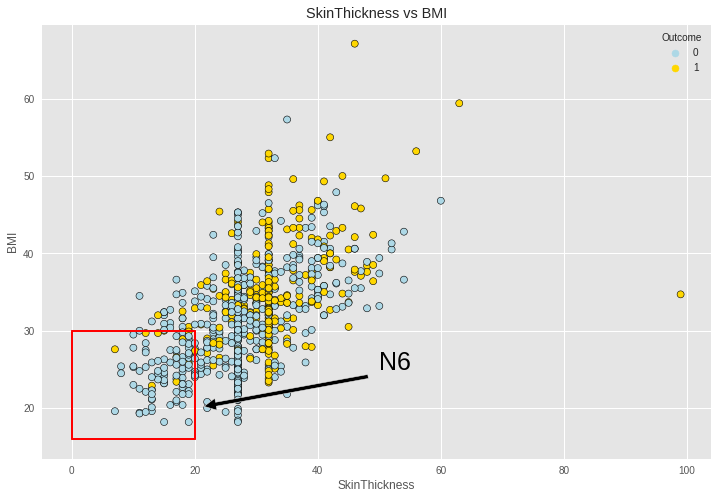

In [58]:
palette = {0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['SkinThickness'], y=data['BMI'], hue = 'Outcome',
                      data = data, palette = palette, edgecolor = edgecolor)

plt.annotate('N6', size=25, color = 'black', xy = (20, 20), xytext=(50, 25),
             arrowprops = dict(facecolor = 'black', shrink = 0.05),)

plt.plot([0, 20], [30, 30], linewidth=2, color='red')
plt.plot([0, 0], [16, 30], linewidth=2, color='red')
plt.plot([0, 20], [16, 16], linewidth = 2, color = 'red')
plt.plot([20, 20], [16, 30], linewidth = 2, color = 'red')
plt.title('SkinThickness vs BMI')
plt.show()

In [59]:
barplot('N6', ': BMI < 30 and SkinThickness <= 20')

Output hidden; open in https://colab.research.google.com to view.

In [60]:
plot_pie('N6','BMI < 30 and SkinThickness <= 20')

Output hidden; open in https://colab.research.google.com to view.

## 4.7 Glucose and BMI

In [61]:
plot_feat1_feat2('Glucose', 'BMI')

Output hidden; open in https://colab.research.google.com to view.

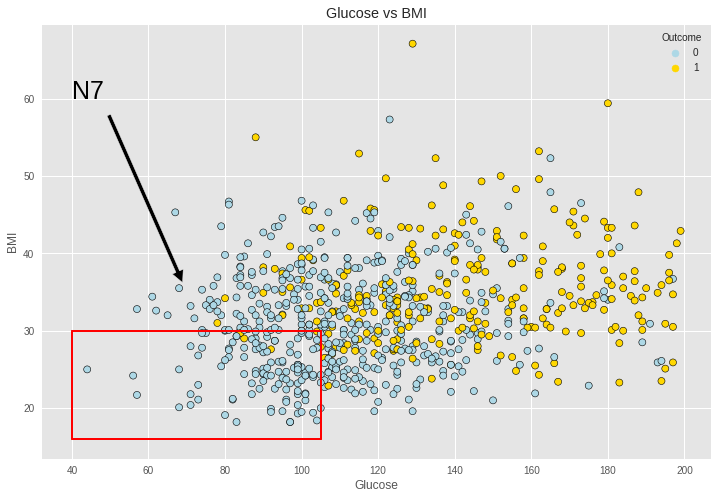

In [62]:
palette = {0 : 'lightblue', 1:'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))
ax1 = sns.scatterplot(x = data['Glucose'], y=data['BMI'], hue = 'Outcome',
                      data = data, palette = palette, edgecolor = edgecolor)

plt.annotate('N7', size=25, color='black', xy=(70,35), xytext=(40,60),
             arrowprops = dict(facecolor = 'black',shrink=0.05),)

plt.plot([105, 105], [16, 30], linewidth = 2, color ='red')
plt.plot([40, 40], [16, 30], linewidth = 2, color = 'red')
plt.plot([40, 105], [16, 16], linewidth = 2, color = 'red')
plt.plot([40, 105], [30, 30], linewidth = 2, color = 'red')
plt.title('Glucose vs BMI')
plt.show()

In [63]:
data.loc[:,'N7'] = 0
data.loc[(data['Glucose']<=105) & (data['BMI']<=30), 'N7'] = 1

In [64]:
barplot('N7', ': Glucose <= 105 and BMI <= 30')

Output hidden; open in https://colab.research.google.com to view.

In [65]:
plot_pie('N7', 'Glucose <= 105 and BMI <= 30')

Output hidden; open in https://colab.research.google.com to view.

## 4.8 Insulin

In [66]:
plot_distribution('Insulin',0)

Output hidden; open in https://colab.research.google.com to view.

In [67]:
data.loc[:,'N9'] = 0
data.loc[(data['Insulin']<200), 'N9'] = 1

In [68]:
barplot('N9', ': Insulin < 200')

Output hidden; open in https://colab.research.google.com to view.

In [69]:
plot_pie('N9', 'Insulin < 200')

Output hidden; open in https://colab.research.google.com to view.

## 4.9 BloodPressure

In [70]:
data.loc[:, 'N10'] = 0
data.loc[(data['BloodPressure'] < 80), 'N10'] =1

In [71]:
barplot('N10', ':BloodPressure < 80')

Output hidden; open in https://colab.research.google.com to view.

In [72]:
plot_pie('N10', 'BloodPressure < 80')

Output hidden; open in https://colab.research.google.com to view.

## 4.10 Pregnancies


In [73]:
plot_distribution('Pregnancies',0)

Output hidden; open in https://colab.research.google.com to view.

In [74]:
data.loc[:, 'N11'] = 0
data.loc[(data['Pregnancies']<4) & (data['Pregnancies']!=0) ,'N11']=1

In [75]:
barplot('N11', ': Pregnancies > 0 and < 4')

Output hidden; open in https://colab.research.google.com to view.

In [76]:
plot_pie('N11', 'Pregnancies > 0 and < 4')

Output hidden; open in https://colab.research.google.com to view.

* Others

In [77]:
data['N0'] = data['BMI'] * data['SkinThickness']

data['N8'] = data['Pregnancies'] / data['Age']

data['N13'] = data['Glucose'] / data['DiabetesPedigreeFunction']

data['N12'] = data['Age'] * data['DiabetesPedigreeFunction']

data['N14'] = data['Age'] / data['Insulin']

In [78]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

In [79]:
plot_distribution('N0', 0)

Output hidden; open in https://colab.research.google.com to view.

In [80]:
data.loc[:,'N15'] = 0
data.loc[(data['N0']<1034), 'N15'] = 1

In [81]:
barplot('N15', ': N0 < 1034')

Output hidden; open in https://colab.research.google.com to view.

In [82]:
plot_pie('N15','N0 < 1034')

Output hidden; open in https://colab.research.google.com to view.

# 5.Prepare dataset


## 5.1 StandardScaler and LabelEncoder
* StandardScaler  
 - 평균을 제거하고 단위 분산에 맞게 조정해 기능을 표준화한다.  

 센터링 및 스케일링은 세트의 샘플에 대한 관련 통계를 계산해 각 기능에서 독립적으로 발생한다. 그런 다음 변환 방법을 사용해 이후 데이터에 사용하기 위해 평균 및 표준 편차를 저장한다. 
 
 데이터 세트의 표준화는 많은 기계 학습 추정기의 일반적인 요구 사항이다. 개별 기능이 <u>표준 정규 분포</u> 데이터처럼 보이지 않는 경우 제대로 작동하지 않을 수 있다.  
 표준 정규 분포
  - 평균(μ)이 0
  - 표준편차(σ) 1
 
* LabeEncoder 
 - 0과 n_classes-1 사이의 값으로 레이블을 인코딩한다.

 우리는 알고리즘에 적절하게 공급하기 위해 데이터를 인코딩한다.

In [83]:
target_col = ['Outcome']
cat_cols = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols = [x for x in cat_cols]


# numerical columns
num_cols = [x for x in data.columns if x not in cat_cols + target_col]

# Binary columns with 2 values
bin_cols = data.nunique()[data.nunique() == 2].keys().tolist()

# Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]


# Label encoding Binary columns
# 이진 변수 Label Encoding
le = LabelEncoder()
for i in bin_cols:
    data[i] = le.fit_transform(data[i])
    
# Dupicating columns for multi value columns 
# 다중 행 중 중복된 값이 있는 열
data = pd.get_dummies(data = data,columns = multi_cols)

# Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)

# dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols, axis=1)
data = data.merge(scaled, left_index = True, right_index = True, how='left')

이제 상관관계를 계산할 수 있다.

## 5.2 상관 행렬  

상관 행렬은 변수 집합 간의 상관 계수를 보여주는 테이블이다.  
표의 각 확률 변수(Xi)는 표(Xj)의 다른 값 각각과 상관 관계가 있다.  
이를 통해 가장 높은 상관 관계를 가진 쌍을 볼 수 있다. 

In [84]:
def correlation_plot():
    configure_plotly_browser_state()

    # correlation
    correlation = data.corr()
    # tick labels
    matrix_cols = correlation.columns.tolist()
    # convert to array
    corr_array = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale = 'Viridis',
                       colorbar = dict(),)
    layout = go.Layout(dict(title = 'Correlation Marix for variables', 
                            # autosize = False,
                            # height = 1400,
                            # width = 1600,
                            margin = dict(r = 0, l = 100,t = 0, b = 100),
                            yaxis = dict(tickfont = dict(size = 9)),
                            xaxis = dict(tickfont = dict(size = 9)),
                            )
                       )
    fig = go.Figure(data = [trace], layout = layout)
    py.iplot(fig)

In [85]:
correlation_plot()

## 5.3 X and y
we define X and y : 

In [86]:
# Def X and y
X = data.drop('Outcome', 1)
y = data['Outcome']

## 5.4 Model Performance
 모델 성능을 측정하려면 몇 가지 요소가 필요하다.

 **필수 부분**
 * **혼동 행렬(Confusino matrix)** : 오류 행렬이라고도 하며 알고리즘의 성능을 시각화 할 수 있다.
  1. True Positive (TP) : 양성 예측(P), 양성 진단(T)
    - 실제 당뇨병에 걸림
  2. True Negative (TN) : 음성 예측(N), 음성 진단(T)
    - 당뇨병이 아니다.
  3. False Positive (FP): 양성 예측(P), 음성 진단(F)
    - 건강하지만 당뇨로 식별
  4. False Negative (FN) : 음성 예측(N), 양성 진단(F)
    - 당뇨지만 건강하다고 식별


* Metrics : 
 * Accuracy(정확도)  : (TP + TN) / (TP + TN + FP + FN)
 * Precision(정밀도) : TP / (TP + FP)
 * Recall(재현율)    : TP / (TP + FN)
 * F1 Score          : 2 * (Precision * Recall) / (Precision + Recall)

* ROC Curve
 - ROC 곡선은 다양한 임계값 설정에서 거짓 양성률(FPR)에 대해 참 양성률(TPR)을 도표화해 생성한다. 

* Precision Recall Curve
 - 다른 임계값에 대한 정밀도와 재현율 간의 균형을 보여준다.




우리의 알고리즘을 훈련하고 검증하기 위해 K-Fold 교차 검증을 수행해야한다. 
        
        K-Fold 교차 검증에서 원본 샘플은 k개의 동일한 크기의 하위 샘플로 무작위로 분할된다.
        K개의 서브샘플 중 하나의 서브샘플은 모델 테스트를 위한 검증 데이터로 유지되고 나머지 k-1개의 서브샘플은 훈련 데이터로 사용된다.
        그런 다음 교차 검증 프로세스가 k번 반복되며 k하위 샘플 각각은 검증 데이터로 정확히 한 번 사용된다. 
        그런 다음 k개의 결과를 평균화해 단일 추정치를 생성할 수 있다. 
        반복되는 무작위 하위 샘플링에 비해 이 방법의 장점은 모든 관찰이 훈련과 검증 모두에 사용되며 각 관찰은 검증에 정확히 한 번 사용된다.

아래에서는 Plotly를 사용해 양식화된 보고서를 정의한다.

In [87]:
def model_performance(model, subtitle) :   
    configure_plotly_browser_state()
    
    #Kfold
    cv = KFold(n_splits=5,shuffle=True, random_state = 42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:,1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y[test], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc) 
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report (5 folds)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

## 5.5 Scores Tabels

In [88]:
# def scores_table(model, subtitle):
#     configure_plotly_browser_state()
    
#     scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
#     res = []
#     for sc in scores:
#         scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
#         res.append(scores)
#     df = pd.DataFrame(res).T
#     df.loc['mean'] = df.mean()
#     df.loc['std'] = df.std()
#     df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

#     trace = go.Table(
#         header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
#                     line = dict(color='#7D7F80'),
#                     fill = dict(color='#a1c3d1'),
#                     align = ['center'],
#                     font = dict(size = 15)),
#         cells=dict(values=[('1','2','3','4','5','mean', 'std'),
#                            np.round(df['accuracy'],3),
#                            np.round(df['precision'],3),
#                            np.round(df['recall'],3),
#                            np.round(df['f1'],3),
#                            np.round(df['roc_auc'],3)],
#                    line = dict(color='#7D7F80'),
#                    fill = dict(color='#EDFAFF'),
#                    align = ['center'], font = dict(size = 15)))

#     layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
#     fig = dict(data=[trace], layout=layout)

#     py.iplot(fig, filename = 'styled_table')

In [97]:
# ver2
def scores_table(model, subtitle):
    configure_plotly_browser_state()
    
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line = dict(color='#7D7F80'),
                    fill = dict(color='#a1c3d1'),
                    align = ['center'],
                    font = dict(size = 15)),
        cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                           np.round(df['accuracy'],3),
                           np.round(df['precision'],3),
                           np.round(df['recall'],3),
                           np.round(df['f1'],3),
                           np.round(df['roc_auc'],3)],
                   line = dict(color='#7D7F80'),
                   fill = dict(color='#EDFAFF'),
                   align = ['center'], font = dict(size = 15)))

    layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
    fig = dict(data=[trace], layout=layout)

    py.iplot(fig, filename = 'styled_table')

# 6.Machine Learning

## 6.1 RandomSearch + LightGBM - Accuracy = 89.8%

**LightGBM**은 트리 기반 학습 알고리즘을 사용하는 그래디언트 부스팅 프레임워크이다. 다음과 같은 이점이 있는 효율적이고 분산되도록 설계되어 있다.

* 더 빠른 훈련 속도와 더 높은 효율성
* 메모리 사용량 감소
* 더 나은 정확도
* 병렬 및 GPU학습 지원
* 대규모 데이터 처리 가능

최적의 매개 변수(Hyperparameters)를 찾기 위해 Random Search CV를 사용할 것이다.   

        Random Search는 하이퍼파리미터의 무작위 조합을 사용해 빌드된 모델에 대한 최상의 솔루션을 찾는 기술이다.
        일반적으로 Random Search는 가능한 모든 조합을 계산하는 GridSearchCV보다 빠르고 정확하다.
        RandomGrid를 사용해 원하는 조합의 수를 지정한다.



* **LightGBM 매개변수(Hyperparameter)**
    * learning_rate 
            최종 결과에 대한 트리의 영향을 결정한다. 
            GBM은 각 트리의 출력을 사용해 업데이트되는 초기 추정값으로 시작해 작동한다. 
            학습 매개변수는 추정치에서 이러한 변화의 크기를 제어한다. 
    * n_estimator
            트리의 갯수(or rounds)
        
    * num_leaves 
            전체 트리의 잎 수. (기본 값:31)

    * min_child_samples 
            하나의 잎에 있는 최소 데이터 수
            (과적합 처리하는데 사용할 수 있다.)
    * min_child_weight
            한 잎의 최소 합
    * subsample
            재표본하지 않고 데이터의 일부를 무작위로 선택
    * max_depth 
            트리의 최대 깊이를 나타낸다. 
            이 매개 변수는 모델 과적합을 처리하는데 사용된다.
    * colsample_bytree
           Colsample_bytree가 1.0보다 작은 경우 LightGBM은 각 반복에서 기능의 일부를 무작위로 선택한다. 
           (예를 들어, 0.8로 설정하면 LightGBM은 각 트리를 훈련하기 전에 기능의 80%를 선택한다.)
    * reg_alpha / reg_lambda
            정규화
    * early_stopping_rounds 
            분석 속도를 높이는데 도움이 될 수 있다.
            하나의 유효성 검사 데이터 중 하나의 메트릭이 마지막 early_stopping_round 라운드에서 개선되지 않으면 
            모델이 학습을 중지한다.
            이렇게하면 과도한 반복을 줄일 수 있다.

        


In [98]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [99]:
model_performance(lgbm_clf, 'LightGBM')
scores_table(lgbm_clf, 'LightGBM')

## 6.2 LightGBM - Discrimination Threshold

* **식별 임계값(Discrimination Threshold)**  

    - 이진 분류기의 식별 임계값에 대한 정밀도, 재현율, F1 Score, 및 대기열 비율의 시각화이다.   
    - 식별 임계값은 음의 클래스보다 양의 클래스가 선택될 확률 또는 점수이다.

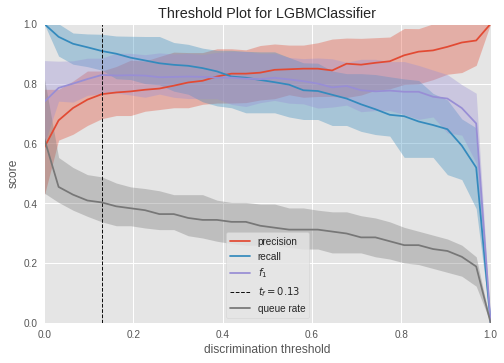

In [100]:
visualizer = DiscriminationThreshold(lgbm_clf)

visualizer.fit(X, y)
visualizer.poof()

## 6.3 GridSearch + LightGBM & KNN - Accuracy = 90.6%  
좋은 결과를 얻었지만 LightGBM(투표 분류기)에 KNeighborsClassifier를 추가하면 90%를 넘길 수 있다.

* KNeighborsClassifier
 - KNeighborsClassifier는 쿼리 포인트의 가장 가까운 이웃 k를 기반으로 학습을 구현한다. 여기서 k는 사용자가 지정한 정수 값이다. 

* VotingClassifier
 - VotingClassifier는 다수 혹은 복수 투표를 통한 분류를 위해 유사하거나 개념적으로 다른 기계 학습 분류기를 결합하기 위한 메타 분류기이다. 

GridSearchCV를 사용해 투표 분류기의 정확도를 최적화하기 위해 최고의 'n_neighbors'를 검색한다.

In [101]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.9062897886427297
Best Parameters: {'knn__n_neighbors': 25}


n_neighbors - 25일때, 정확도는 90.624로 증가한다.  
(모델 성능 보고서는 아래 표시된다.)

In [102]:
knn_clf = KNeighborsClassifier(n_neighbors=25)

voting_clf = VotingClassifier(
    estimators = [('knn', knn_clf), ('lgbm', lgbm_clf)],
    voting='soft', weights=[1,1]
)

In [103]:
configure_plotly_browser_state()
model_performance(voting_clf, 'LightGBM & KNN')
scores_table(voting_clf, 'LightGBM & KNN')

## 6.4 LightGBM & KNN - Discrimination Threshold

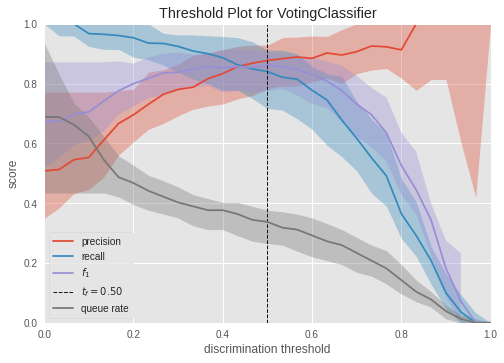

In [104]:
visualizer = DiscriminationThreshold(voting_clf)

visualizer.fit(X, y)
visualizer.poof()

>[개발자를 위한 정보 검색 팁](https://boxnwhis.kr/2020/09/27/ir-for-developers.html)